<a href="https://colab.research.google.com/github/msuriya2001/machine-learning-lab-exercises/blob/main/labex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os

In [2]:
dataset = tf.keras.utils.get_file(
    "image_data"," https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar",
    untar = True
)


In [3]:
os.path.dirname(dataset)

'/root/.keras/datasets'

In [4]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')


In [5]:
import scipy.io
# extract data from wiki.mat
mat = scipy.io.loadmat(os.path.join(dataset_dir,'wiki.mat'))

In [6]:
mat 


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 arr

In [30]:
gender = mat["wiki"]["gender"][0][0][0]

# gender = np.array(gender)
# nan_indices = np.where(gender == "nan")
# nan_indices 
# for i in range(400, 450):
#     print(gender[i])

index = np.where(np.isnan(gender) == False)[0]
gender = mat["wiki"]["gender"][0][0][0][index]
gender 

array([1., 1., 1., ..., 1., 1., 0.])

In [31]:
file_path =list( map(lambda x: os.path.join(dataset_dir, x[0]), mat["wiki"]["full_path"][0][0][0][index]))


In [32]:
from sklearn.model_selection import train_test_split


In [33]:
file_age_ds = tf.data.Dataset.from_tensor_slices((file_path,gender))
x_train, x_test, y_train, y_test = train_test_split(file_path, gender, test_size = 0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.9)

In [34]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [35]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels=1)
    image = tf.image.resize(image_decoded, [256, 256])
    return image, tf.expand_dims(label,0)

In [36]:
#ds_train = ds_train.filter(lambda image: image.shape[0] >= 256)

In [37]:
train_ds = train_ds.map(parse_function)
test_ds = test_ds.map(parse_function)
val_ds = val_ds.map(parse_function)

In [38]:
train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)
val_ds = val_ds.batch(256)

In [ ]:
import tensorflow.keras.layers as tfl


In [ ]:
model = tf.keras.Sequential([
    tfl.Conv2D(32,(5,5),padding="same",activation="relu",input_shape=(256,256,1)),
    tfl.MaxPool2D((4,4),strides = 2),
    tfl.Conv2D(32,(5,5),padding = "valid",activation="relu"),
    tfl.MaxPool2D((4,4),strides = 4),
    tfl.Conv2D(64,(5,5),padding = "valid",activation="relu"),
    tfl.MaxPool2D((4,4),strides = 4),
    tfl.Conv2D(128,(3,3),padding= "valid",activation="relu",),
    tfl.MaxPool2D((2,2),strides = 2),
    tfl.Conv2D(256, (1,1), padding = "valid", activation = "relu"),
    tfl.MaxPool2D((2,2), strides = 2),
    tfl.Flatten(),
    tfl.Dense(64,activation="relu"),
    tfl.Dense(1)                             
])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      832       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 123, 123, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)        

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['MAE']
)

In [42]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10)

Epoch 1/10
168/168 [==============================] - 71s 394ms/step - loss: 0.5125 - MAE: 0.5125 - val_loss: 0.2439 - val_MAE: 0.2439
Epoch 2/10
168/168 [==============================] - 61s 362ms/step - loss: 0.2245 - MAE: 0.2245 - val_loss: 0.2168 - val_MAE: 0.2168
Epoch 3/10
168/168 [==============================] - 61s 362ms/step - loss: 0.2164 - MAE: 0.2164 - val_loss: 0.2157 - val_MAE: 0.2157
Epoch 4/10
168/168 [==============================] - 61s 362ms/step - loss: 0.2154 - MAE: 0.2154 - val_loss: 0.2133 - val_MAE: 0.2133
Epoch 5/10
168/168 [==============================] - 61s 360ms/step - loss: 0.2177 - MAE: 0.2177 - val_loss: 0.2126 - val_MAE: 0.2126
Epoch 6/10
168/168 [==============================] - 61s 359ms/step - loss: 0.2172 - MAE: 0.2172 - val_loss: 0.2144 - val_MAE: 0.2144
Epoch 7/10
168/168 [==============================] - 61s 360ms/step - loss: 0.2153 - MAE: 0.2153 - val_loss: 0.2134 - val_MAE: 0.2134
Epoch 8/10
168/168 [==============================] - 6

In [43]:
history  = history.history

In [45]:
history.keys()

dict_keys(['loss', 'MAE', 'val_loss', 'val_MAE'])

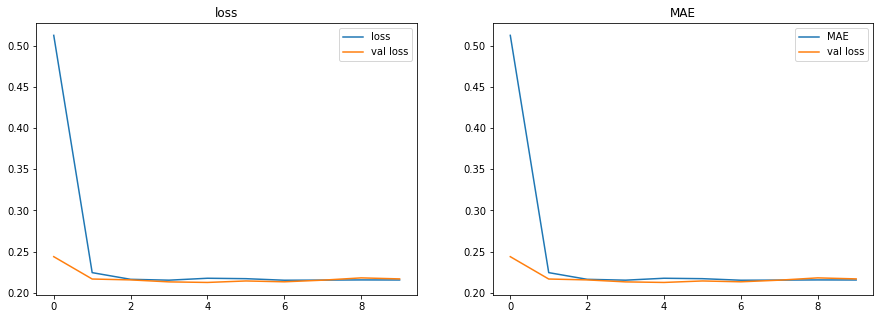

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("loss")
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.subplot(122)
plt.title("MAE")
plt.plot(history["MAE"],label="MAE")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()